In [15]:
!pip install huggingface_hub
!pip install labml
!pip install labml_nn
!pip install labml_helpers
!pip install --upgrade torchtext

In [16]:
from google.colab import userdata

In [17]:
from typing import Optional
import torch
from torch import nn

from labml import experiment
from labml.configs import option
from labml_helpers.module import Module
#from labml_nn.experiments.nlp_classification import NLPClassificationConfigs
from labml_nn.transformers import Encoder
from labml_nn.transformers import TransformerConfigs

In [18]:
class FNetMix(nn.Module):

  def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: Optional[torch.Tensor] = None):
    #masking is unsupported in Fnet
    #key,query and value all same (required for fnet)
    assert query is key and key is value
    assert mask is None

    x = query
    # fft_hidden = torch.fft.fft(x, dim=2) #Fourier transform along hidden dim
    # fft_seq = torch.fft.fft(fft_hidden, dim=0) #FT along seq dim

    fft = torch.fft.fft2(x) #2D FFT operation

    return torch.real(fft)#real part


In [19]:
class FNetMixExtended(nn.Module):

    def __init__(self, d_model, dropout=0.1):
        super(FNetMixExtended, self).__init__()
        self.fourier_mixing = FNetMix()

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.fourier_mixing(x, x, x))
        x = self.layer_norm_1(x)
        x = x + self.dropout(self.ffn(x))
        x = self.layer_norm_2(x)
        return x


In [20]:
class FNetEncoder(nn.Module):

    def __init__(self, num_layers, d_model, vocab_size, max_seq_len, dropout=0.1):
        super(FNetEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model))
        #Stack of FNetMixExtended layers
        self.layers = nn.ModuleList([FNetMixExtended(d_model, dropout) for _ in range(num_layers)])
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.position_encoding[:, :x.size(1), :]
        for layer in self.layers:
            x = layer(x)
        return self.output_projection(x)


In [21]:
def test_fnet_mix():
    seq_len = 10
    batch_size = 2
    d_model = 16

    #generate random input tensor
    x = torch.rand(seq_len, batch_size, d_model)
    fnet_layer = FNetMix()
    #pass
    output = fnet_layer(x, x, x)  # query, key, value are all x
    print(f"Output shape: {output.shape}")

    #checking output shape
    if output.shape == (seq_len, batch_size, d_model):
        print("Test passed: Output shape matches expected shape.")
    else:
        print("Test failed: Output shape does not match expected shape.")

    #actual output tensor for verification
    print("Actual Output tensor:", output)
    print("FNetMix test passed.")

test_fnet_mix()

Output shape: torch.Size([10, 2, 16])
Test passed: Output shape matches expected shape.
Actual Output tensor: tensor([[[ 1.6153e+01,  5.0703e-01,  2.8108e-01,  9.8996e-01, -3.3081e-01,
           3.5454e-01, -2.6076e+00,  1.2387e+00,  4.7085e-01,  1.2387e+00,
          -2.6076e+00,  3.5454e-01, -3.3081e-01,  9.8996e-01,  2.8108e-01,
           5.0703e-01],
         [-1.5510e+00, -9.3509e-01,  3.8885e-01, -1.0193e+00, -5.6208e-01,
           5.3269e-03, -4.8080e-01,  3.6665e-01,  1.3563e+00,  3.6665e-01,
          -4.8080e-01,  5.3269e-03, -5.6208e-01, -1.0193e+00,  3.8885e-01,
          -9.3509e-01]],

        [[ 1.2618e+01, -1.7419e+00,  2.7057e-01, -7.1511e-01,  1.0779e+00,
          -1.7444e-01, -7.0610e-01, -9.3431e-01, -2.6049e+00, -9.3431e-01,
          -7.0610e-01, -1.7444e-01,  1.0779e+00, -7.1511e-01,  2.7057e-01,
          -1.7419e+00],
         [ 2.3545e+00, -1.2265e+00, -2.4957e-01, -1.0875e+00,  9.2081e-01,
           2.1131e+00, -1.4460e+00,  3.9447e-01, -1.1652e+00,  3.9

In [22]:
def test_fnet_mix_extended():
    seq_len = 10
    batch_size = 2
    d_model = 16
    #generate random input tensor
    x = torch.rand(seq_len, batch_size, d_model)
    fnet_mix_extended = FNetMixExtended(d_model)
    output = fnet_mix_extended(x)

    print(f"Output shape of FNetMixExtended: {output.shape}")

    if output.shape == (seq_len, batch_size, d_model):
        print("Test passed: FNetMixExtended output shape matches expected shape.")
    else:
        print("Test failed: FNetMixExtended output shape does not match expected shape.")

    print("Output of FNetMixExtended:", output)


def test_fnet_encoder():
    seq_len = 10
    batch_size = 2
    d_model = 16
    num_layers = 4
    vocab_size = 100
    max_seq_len = 20

    #generate random input tensor
    x = torch.randint(0, vocab_size, (batch_size, seq_len))
    fnet_encoder = FNetEncoder(num_layers, d_model, vocab_size, max_seq_len)
    output = fnet_encoder(x)
    print(f"Output shape of FNetEncoder: {output.shape}")

    if output.shape == (batch_size, seq_len, vocab_size):
        print("Test passed: FNetEncoder output shape matches expected shape.")
    else:
        print("Test failed: FNetEncoder output shape does not match expected shape.")

    #verification
    print("Actual Output of FNetEncoder:", output)

test_fnet_mix_extended()
test_fnet_encoder()


Output shape of FNetMixExtended: torch.Size([10, 2, 16])
Test passed: FNetMixExtended output shape matches expected shape.
Output of FNetMixExtended: tensor([[[ 3.7473e+00,  4.7624e-02, -5.0845e-01, -6.1314e-01, -5.6042e-01,
          -5.5853e-01, -2.5351e-01, -6.7096e-02, -3.2274e-01,  7.6065e-02,
           2.7213e-03, -2.0073e-01,  1.0598e-01, -6.6029e-01, -1.4205e-01,
          -9.2715e-02],
         [-1.2899e+00, -1.2685e-01,  4.7051e-01, -1.9260e+00,  1.6863e+00,
          -1.1903e-01,  1.4991e-01, -5.3132e-01,  1.8285e-01, -1.3107e-01,
           5.6751e-01,  6.0532e-01,  1.6249e+00, -1.7769e+00,  8.0739e-01,
          -1.9370e-01]],

        [[ 3.5077e+00,  3.4484e-01,  3.1502e-01, -5.7195e-01, -1.2172e-01,
           6.5747e-03, -2.8954e-01, -8.6767e-01, -1.2874e+00, -4.9489e-01,
          -3.8656e-01,  1.2768e-01, -2.9591e-01, -2.9947e-01,  1.0744e-01,
           2.0595e-01],
         [-2.3654e+00,  8.9708e-01, -7.7900e-01,  1.3583e+00, -1.3861e+00,
          -2.1055e-01, -9.

Sequence Length: 512
FNetEncoder - Inference Time: 12.74 ms/batch, Memory Usage: 1844.21 MB
BERT - Inference Time: 7820.37 ms/batch, Memory Usage: 1949.21 MB
Inference Time Reduction (FNet vs. BERT): 99.84%

Memory Reduction (FNet vs. BERT): 5.39%

Sequence Length: 1024
FNetEncoder - Inference Time: 12.71 ms/batch, Memory Usage: 1949.21 MB
BERT - Inference Time: 14797.94 ms/batch, Memory Usage: 1976.15 MB
Inference Time Reduction (FNet vs. BERT): 99.91%

Memory Reduction (FNet vs. BERT): 1.36%



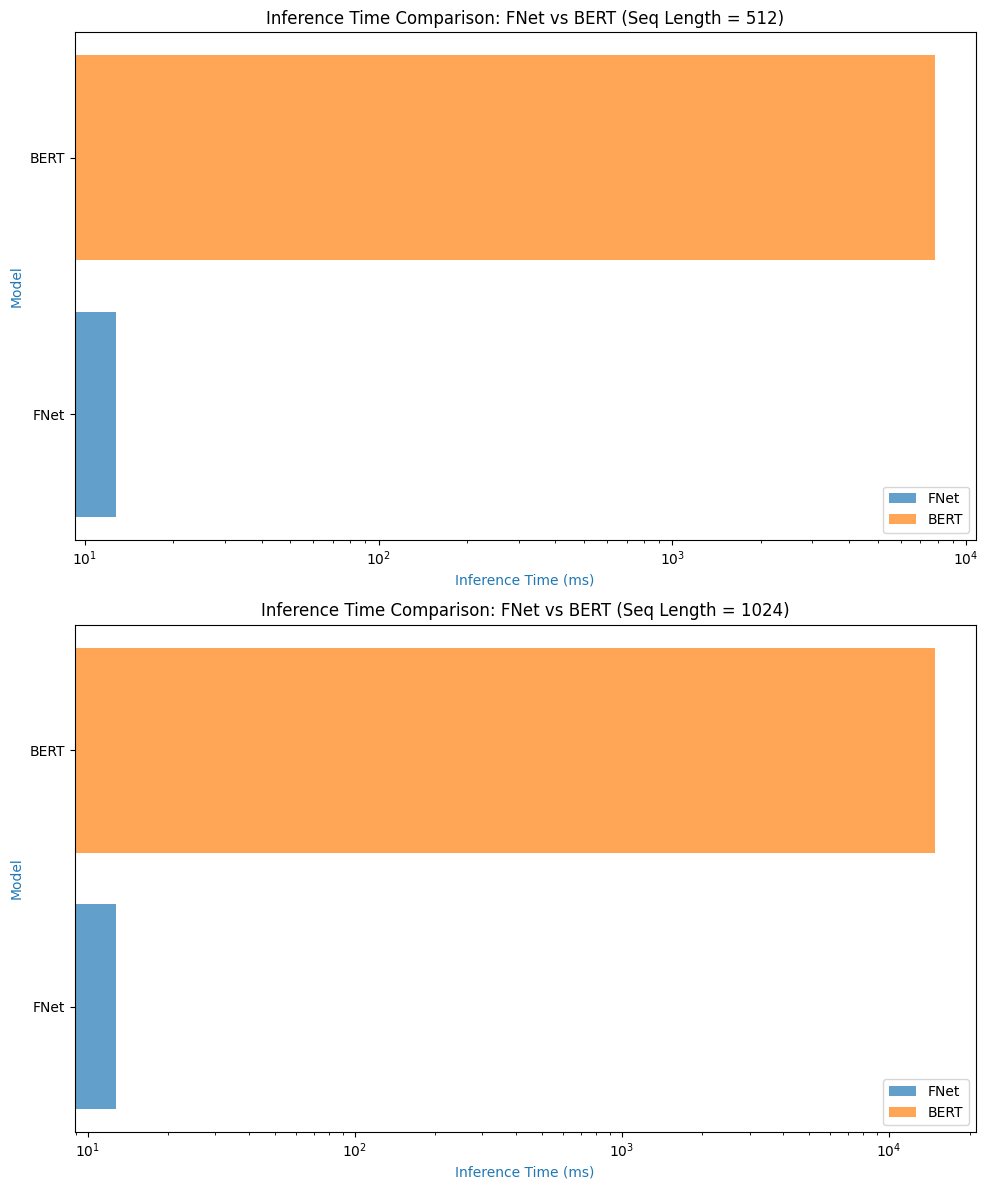

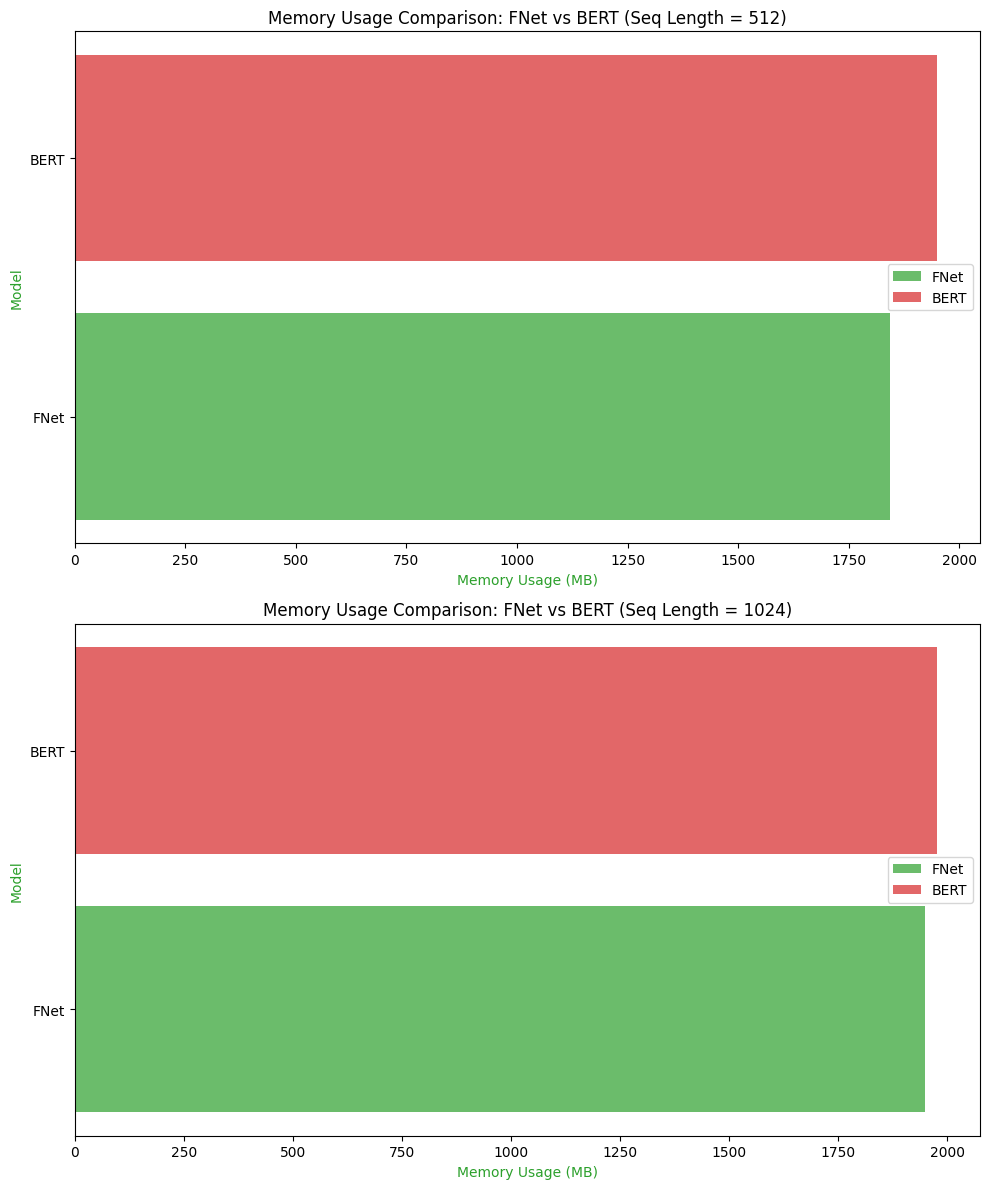

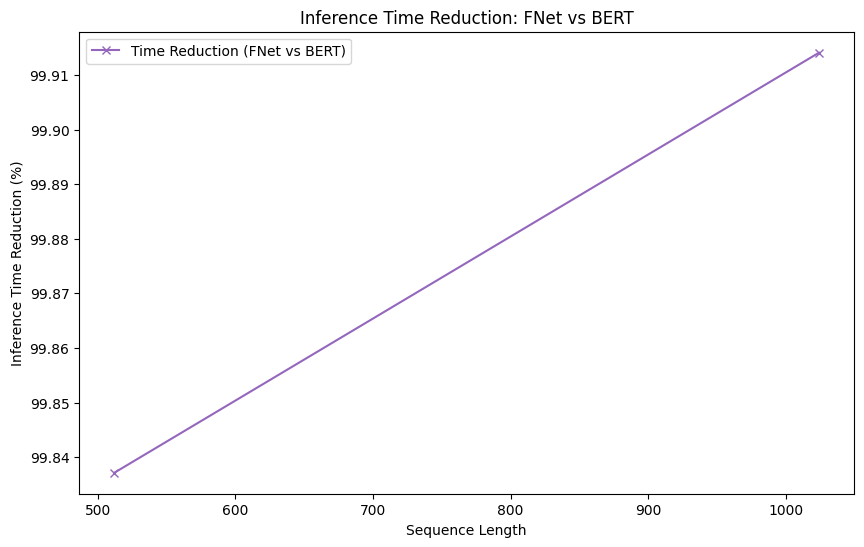

In [23]:
import time
import torch
import psutil
import matplotlib.pyplot as plt
from transformers import BertModel

def measure_efficiency(model, seq_len, vocab_size, batch_size):
    #dummy data
    input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    input_ids = input_ids.to(device)

    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats(device)
        torch.cuda.empty_cache()

    #inference speed
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        #initial_memory = torch.cuda.memory_allocated(device) if device.type == "cuda" else psutil.Process().memory_info().rss

        for _ in range(10):
            if isinstance(model, BertModel):
                attention_mask = torch.ones(batch_size, seq_len, dtype=torch.long).to(device)
                token_type_ids = torch.zeros(batch_size, seq_len, dtype=torch.long).to(device)
                #handle seq > 512
                position_ids = torch.arange(0, seq_len, dtype=torch.long).unsqueeze(0).repeat(batch_size, 1).to(device)
                if seq_len > 512:
                    position_ids = position_ids % 512  #cap max
                output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids).last_hidden_state
            else:
                output = model(input_ids)
        peak_memory = torch.cuda.memory_allocated(device) if device.type == "cuda" else psutil.Process().memory_info().rss

    inference_time = (time.time() - start_time) / 10 * 1000
    if device.type == "cuda":
        peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        torch.cuda.empty_cache()
    else:
        peak_memory = psutil.Process().memory_info().rss / (1024 ** 2)

    return inference_time, peak_memory

#FNet vs BERT
def compare_models(fnet_model, bert_model, seq_lengths, vocab_size_fnet, vocab_size_bert):
    fnet_times, bert_times, fnet_memories, bert_memories, time_reductions = [], [], [], [], []
    for seq_len in seq_lengths:
        print(f"Sequence Length: {seq_len}")
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.empty_cache()

        #fnet
        with torch.no_grad():
          fnet_time, fnet_memory = measure_efficiency(fnet_model, seq_len, vocab_size=400, batch_size = 3)
        fnet_times.append(fnet_time)
        fnet_memories.append(fnet_memory)
        print(f"FNetEncoder - Inference Time: {fnet_time:.2f} ms/batch, Memory Usage: {fnet_memory:.2f} MB")

        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.empty_cache()
        #bert
        with torch.no_grad():
          bert_time, bert_memory = measure_efficiency(bert_model, seq_len, vocab_size=30522, batch_size = 3)
        bert_times.append(bert_time)
        bert_memories.append(bert_memory)
        print(f"BERT - Inference Time: {bert_time:.2f} ms/batch, Memory Usage: {bert_memory:.2f} MB")

        time_reduction = ((bert_time - fnet_time) / bert_time) * 100
        time_reductions.append(time_reduction)
        memory_reduction = ((bert_memory - fnet_memory) / bert_memory) * 100
        print(f"Inference Time Reduction (FNet vs. BERT): {time_reduction:.2f}%\n")
        print(f"Memory Reduction (FNet vs. BERT): {memory_reduction:.2f}%\n")

    return fnet_times, bert_times, fnet_memories, bert_memories, time_reductions

fnet_model = FNetEncoder(num_layers=4, d_model=16, vocab_size=1000, max_seq_len=8192)
bert_model = BertModel.from_pretrained("bert-base-uncased")

sequence_lengths = [512, 1024]
fnet_times, bert_times, fnet_memories, bert_memories, time_reductions = compare_models(fnet_model, bert_model, sequence_lengths, vocab_size_fnet=500, vocab_size_bert=30522)

#plots
fig, (ax1_512, ax1_1024) = plt.subplots(2, 1, figsize=(10, 12))

ax1_512.set_xlabel('Inference Time (ms)', color='tab:blue')
ax1_512.set_ylabel('Model', color='tab:blue')
ax1_512.barh(['FNet'], fnet_times[0], color='tab:blue', alpha=0.7, label='FNet')
ax1_512.barh(['BERT'], bert_times[0], color='tab:orange', alpha=0.7, label='BERT')
ax1_512.set_title('Inference Time Comparison: FNet vs BERT (Seq Length = 512)')
ax1_512.set_xscale('log')
ax1_512.legend()

ax1_1024.set_xlabel('Inference Time (ms)', color='tab:blue')
ax1_1024.set_ylabel('Model', color='tab:blue')
ax1_1024.barh(['FNet'], fnet_times[1], color='tab:blue', alpha=0.7, label='FNet')
ax1_1024.barh(['BERT'], bert_times[1], color='tab:orange', alpha=0.7, label='BERT')
ax1_1024.set_title('Inference Time Comparison: FNet vs BERT (Seq Length = 1024)')
ax1_1024.set_xscale('log')
ax1_1024.legend()

fig2, (ax2_512, ax2_1024) = plt.subplots(2, 1, figsize=(10, 12))

ax2_512.set_xlabel('Memory Usage (MB)', color='tab:green')
ax2_512.set_ylabel('Model', color='tab:green')
ax2_512.barh(['FNet'], fnet_memories[0], color='tab:green', alpha=0.7, label='FNet')
ax2_512.barh(['BERT'], bert_memories[0], color='tab:red', alpha=0.7, label='BERT')
ax2_512.set_title('Memory Usage Comparison: FNet vs BERT (Seq Length = 512)')
ax2_512.legend()

ax2_1024.set_xlabel('Memory Usage (MB)', color='tab:green')
ax2_1024.set_ylabel('Model', color='tab:green')
ax2_1024.barh(['FNet'], fnet_memories[1], color='tab:green', alpha=0.7, label='FNet')
ax2_1024.barh(['BERT'], bert_memories[1], color='tab:red', alpha=0.7, label='BERT')
ax2_1024.set_title('Memory Usage Comparison: FNet vs BERT (Seq Length = 1024)')
ax2_1024.legend()

fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.set_xlabel('Sequence Length')
ax3.set_ylabel('Inference Time Reduction (%)')
ax3.plot(sequence_lengths, time_reductions, color='tab:purple', marker='x', linestyle='-', label="Time Reduction (FNet vs BERT)")
ax3.set_title('Inference Time Reduction: FNet vs BERT')
ax3.legend()

fig.tight_layout()
fig2.tight_layout()

plt.show()


In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, FNetForSequenceClassification
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Sample text data and label
texts = [
    "The sky is clear today.",
    "I love programming with Python.",
    "This restaurant has great food.",
    "The weather is terrible outside.",
    "Learning machine learning is fun.",
    "Artificial intelligence will change the world.",
    "This movie is amazing!",
    "I enjoy reading science fiction books.",
    "The new tech gadget is revolutionary.",
    "It is very hot today.",
    "Coffee helps me focus better.",
    "The game was very exciting.",
    "I can't wait for the weekend.",
    "This place has excellent service.",
    "Running is good for your health.",
    "I need to buy groceries today.",
    "My favorite hobby is painting.",
    "She enjoys playing chess in her free time.",
    "We need to plan the trip soon.",
    "My car is making a strange noise."
]
labels = [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]  # Just an example, 1 for positive, 0 for negative class

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Texts to tokens
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Inputs and labels to tensors
inputs_tensor = inputs['input_ids']
attention_mask_tensor = inputs['attention_mask']
labels_tensor = torch.tensor(labels)

dataset = TensorDataset(inputs_tensor, attention_mask_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Pre-trained models
# When initializing the models, specify num_labels=2 since you have binary classification:
fnet_model = FNetForSequenceClassification.from_pretrained("google/fnet-base", num_labels=2)
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# And modify the fine_tune_model function to properly handle the loss:
def fine_tune_model(model, data_loader, num_epochs=3, learning_rate=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    num_train_steps = len(data_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in data_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            if isinstance(model, FNetForSequenceClassification):
                model_inputs = {'input_ids': input_ids, 'labels': labels}
            else:
                attention_mask = attention_mask.to(device)
                model_inputs = {
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'labels': labels
                }

            optimizer.zero_grad()

            outputs = model(**model_inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update metrics
            total_loss += loss.item()
            logits = outputs.logits
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

        avg_loss = total_loss / len(data_loader)
        accuracy = correct_predictions / total_predictions * 100
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


print("Fine-tuning FNet...")
fine_tune_model(fnet_model, data_loader)

print("Fine-tuning BERT...")
fine_tune_model(bert_model, data_loader)

def evaluate_text_classification(fnet_model, bert_model, data_loader):
    fnet_model.eval()
    bert_model.eval()
    print(f"Data Loader Size: {len(data_loader)}")
    fnet_preds, bert_preds, true_labels = [], [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fnet_model = fnet_model.to(device)
    bert_model = bert_model.to(device)

    try:
        with torch.no_grad():
            for batch_idx, batch in enumerate(data_loader):

                inputs, attention_mask, labels = batch
                inputs = {'input_ids': inputs.to(device), 'attention_mask': attention_mask.to(device)}
                true_labels.extend(labels.numpy())

                fnet_inputs = {'input_ids': inputs['input_ids']}
                fnet_outputs = fnet_model(**fnet_inputs).logits.argmax(dim=-1)
                fnet_preds.extend(fnet_outputs.cpu().numpy())

                bert_outputs = bert_model(**inputs).logits.argmax(dim=-1)
                bert_preds.extend(bert_outputs.cpu().numpy())

    except Exception as e:
        print(f"Error occurred: {e}")
        import traceback
        traceback.print_exc()

    fnet_accuracy = accuracy_score(true_labels, fnet_preds)
    bert_accuracy = accuracy_score(true_labels, bert_preds)

    print(f"FNetEncoder Accuracy: {fnet_accuracy * 100:.2f}%")
    print(f"BERT Accuracy: {bert_accuracy * 100:.2f}%")

evaluate_text_classification(fnet_model, bert_model, data_loader)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of FNetForSequenceClassification were not initialized from the model checkpoint at google/fnet-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning FNet...
Epoch 1/3, Loss: 0.6920, Accuracy: 70.00%
Epoch 2/3, Loss: 0.6333, Accuracy: 70.00%
Epoch 3/3, Loss: 0.6251, Accuracy: 70.00%
Fine-tuning BERT...
Epoch 1/3, Loss: 0.7747, Accuracy: 25.00%
Epoch 2/3, Loss: 0.6192, Accuracy: 70.00%
Epoch 3/3, Loss: 0.6399, Accuracy: 70.00%
Data Loader Size: 10
FNetEncoder Accuracy: 70.00%
BERT Accuracy: 70.00%


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, FNetTokenizer, BertModel, FNetModel

fnet_tokenizer = FNetTokenizer.from_pretrained("google/fnet-base")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

fnet_model = FNetModel.from_pretrained("google/fnet-base")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def generate_embeddings(model, sentences, tokenizer):
    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        output = model(**inputs)
        sentence_embedding = output.last_hidden_state.mean(dim=1)
        embeddings.append(sentence_embedding.detach().numpy().flatten())
    return embeddings

sentences = ["The quick brown fox jumps over the lazy dog.",
             "A fast, brown animal leaped over a sleepy canine.",
             "The weather is sunny today."]

fnet_embeddings = generate_embeddings(fnet_model, sentences, fnet_tokenizer)
bert_embeddings = generate_embeddings(bert_model, sentences, bert_tokenizer)

#cosine similarities
fnet_similarities = cosine_similarity(fnet_embeddings)
bert_similarities = cosine_similarity(bert_embeddings)

print("FNet Encoder Similarities:", fnet_similarities)
print("BERT Similarities:", bert_similarities)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


FNet Encoder Similarities: [[1.0000004  0.51133716 0.38006192]
 [0.51133716 1.0000002  0.2994054 ]
 [0.38006192 0.2994054  1.0000002 ]]
BERT Similarities: [[1.         0.8043942  0.54588324]
 [0.8043942  1.0000002  0.46172208]
 [0.54588324 0.46172208 0.9999997 ]]


In [26]:
pip freeze > requirements.txt